<a href="https://colab.research.google.com/github/RKS8347/DL-projects/blob/main/flower_classificationSolving_case_study_using_computer_vision_and_Deployment_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import pathlib

# Downloading data set from URL

In [ ]:
import tensorflow as tf
import pathlib

# Dataset URL
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

# Download and extract the dataset
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)

# Convert to pathlib.Path object for easier handling
data_dir = pathlib.Path(data_dir)

# Optionally, print the path to confirm
print(data_dir)


228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
/root/.keras/datasets/flower_photos


# **Exploring datasets**


In [ ]:
# image count
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


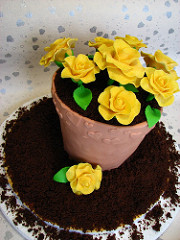

In [ ]:
# explore fist image
roses=list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

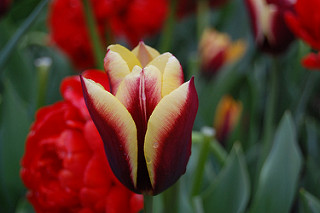

In [ ]:
# explore fist TULIP image
tulips=list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[14]))

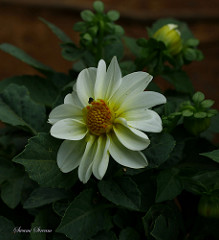

In [ ]:
# explore fist TULIP image
daisy=list(data_dir.glob('daisy/*'))
PIL.Image.open(str(daisy[5]))

In [ ]:
# Define batch size,height and width of the image
batch_size = 32
img_height = 180
img_width = 180

# Creating training and validation subset

In [ ]:
import tensorflow as tf

# Define batch size, height, and width of the image
batch_size = 32
img_height = 180
img_width = 180

# splitting into train and validation dataset.
train_ds = tf.keras.utils.image_dataset_from_directory( # Changed tf.keras.preprocessing to tf.keras.utils
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
# checking the class names of flowers.
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# **Visualize the data**

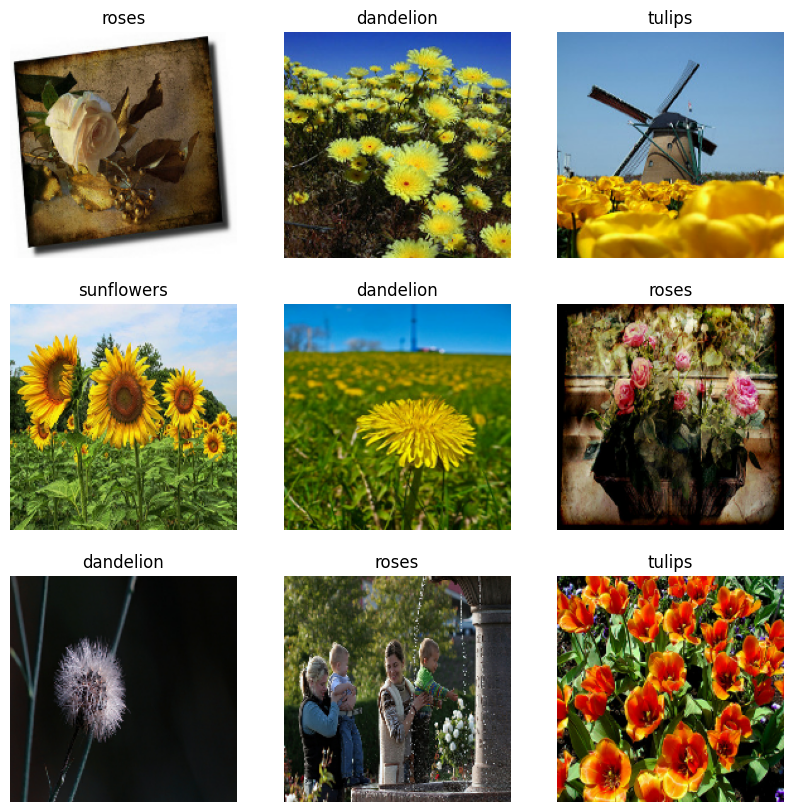

In [ ]:
import matplotlib.pyplot as plt
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# **Checking size of image_batch and labels_batch**

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


# configuiring datasest for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
import tensorflow as tf # Make sure to import tensorflow

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **standardization of the data**

In [ ]:
normalizing_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalizing_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# We are watching that pixel values are now in ['0,1']
print(np.min(first_image), np.max(first_image))

0.0 1.0


# **Building CNN Models**

In [ ]:
num_class=5

model=Sequential([
    layers.Rescaling(1./255,input_shape=(img_height,img_width,3)),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_class)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# **Compile the model**

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

# training model

In [ ]:
epochs=10
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.3695 - loss: 1.5093 - val_accuracy: 0.5627 - val_loss: 1.1109
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.5939 - loss: 1.0272 - val_accuracy: 0.5913 - val_loss: 1.0748
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.6674 - loss: 0.8554 - val_accuracy: 0.6294 - val_loss: 0.9530
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.7629 - loss: 0.6588 - val_accuracy: 0.6471 - val_loss: 0.9895
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.8615 - loss: 0.4188 - val_accuracy: 0.6322 - val_loss: 1.0836
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.9080 - loss: 0.2929 - val_accuracy: 0.6362 - val_loss: 1.0710
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.9650 - loss: 0.1311 - val_accuracy: 0.6131 - val_loss: 1.4397
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9878 - loss: 0.0602 - val_accuracy: 0.6185 - val_los

# plotting graph for comparision of training and validation accuracy.

Text(0.5, 1.0, 'Training and Validation Accuracy')

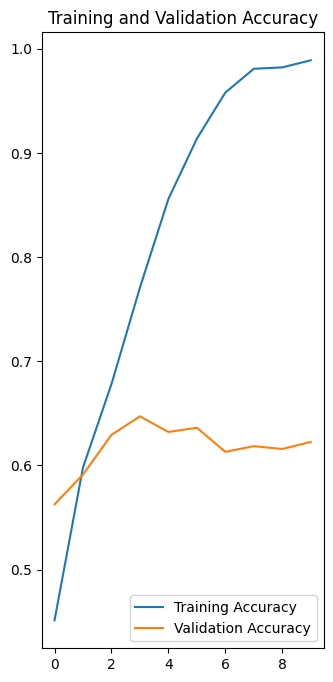

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs_range=range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# **CONCLUSION**

# Training accuracy aroung 98% where validation accuracy is not even 70%.
# shows that CNN model is overfitting.Sothis problem can be solved by using some other model RESNET

# **Classification Using Resnet**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, InputLayer
from tensorflow.keras.optimizers import Adam

# Make sure img_height and img_width are defined
img_height = 180  # Example height
img_width = 180   # Example width

# Create a Sequential model
resnet_model = Sequential()

# Add an InputLayer explicitly (so that the model knows the input shape)
resnet_model.add(InputLayer(input_shape=(img_height, img_width, 3)))

# Build the ResNet50 model without the top layers
pretrained_model = ResNet50(include_top=False,
                            input_shape=(img_height, img_width, 3),
                            pooling='avg',
                            weights='imagenet')

# Freeze the pretrained ResNet layers
for layer in pretrained_model.layers:
    layer.trainable = False

# Add the pretrained ResNet model to the Sequential model
resnet_model.add(pretrained_model)

# Add a Flatten layer
resnet_model.add(Flatten())

# Add a fully connected layer
resnet_model.add(Dense(512, activation='relu'))

# Add the output layer (5 classes for flower classification)
resnet_model.add(Dense(5, activation='softmax'))

# Compile the model
resnet_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                     metrics=['accuracy'])

# Summary of the model
resnet_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 1,051,653 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# **TRAINING THE MODEL USING EPOCHS**
# watching that Data is very large
# we will using 10epochs to train our model.

In [ ]:
epochs=10
history=resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 409s 4s/step - accuracy: 0.6356 - loss: 1.3267 - val_accuracy: 0.8365 - val_loss: 0.4128
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 440s 4s/step - accuracy: 0.9034 - loss: 0.2695 - val_accuracy: 0.8597 - val_loss: 0.3941
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 399s 4s/step - accuracy: 0.9514 - loss: 0.1529 - val_accuracy: 0.8379 - val_loss: 0.5015
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 443s 4s/step - accuracy: 0.9610 - loss: 0.1269 - val_accuracy: 0.8651 - val_loss: 0.3971
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 402s 4s/step - accuracy: 0.9798 - loss: 0.0681 - val_accuracy: 0.8760 - val_loss: 0.3639
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 442s 4s/step - accuracy: 0.9912 - loss: 0.0385 - val_accuracy: 0.8787 - val_loss: 0.4093
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 440s 4s/step - accuracy: 0.9935 - loss: 0.0265 - val_accuracy: 0.8747 - val_loss: 0.4442
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 398s 4s/step - accuracy: 0.9934 - loss: 0.0296 - val_accuracy: 0.8828 - v

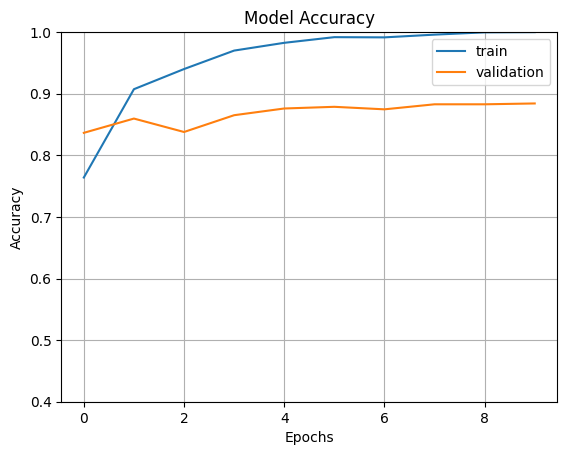

In [ ]:
# plotting training and validation accuracy
fig1=plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# conclusion
# RESNET out perform CNN model when dealing with large data sets.

(1, 180, 180, 3)


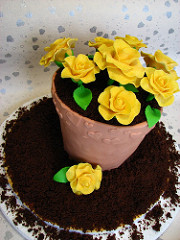

In [ ]:
# Visulaizing image of rose and tulips using cv2
import PIL
import cv2
roses=list(data_dir.glob('roses/*'))
img=cv2.imread(str(roses[0]))
image_resized=cv2.resize(img,(180,180))
image_1=np.expand_dims(image_resized,axis=0)
print(image_1.shape)

PIL.Image.open(str(roses[0]))

(1, 180, 180, 3)


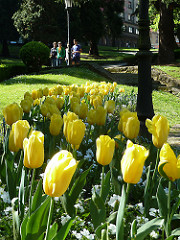

In [ ]:
# Visulaizing image of tulips using cv2

import cv2
tulips=list(data_dir.glob('tulips/*'))
img=cv2.imread(str(tulips[2]))
image_resized=cv2.resize(img,(180,180))
image_2=np.expand_dims(image_resized,axis=0)
print(image_2.shape)

PIL.Image.open(str(tulips[2]))

In [ ]:
# predicting using resnet model that we have built
pred_1=resnet_model.predict(image_1)


pred_2=resnet_model.predict(image_2)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


In [ ]:
output_class=class_names[np.argmax(pred_1)]
print("The Predicted class is",output_class)

output_class=class_names[np.argmax(pred_2)]
print("The Predicted class is",output_class)

The Predicted class is roses
The Predicted class is tulips


# We can see that using RESNET our validation accuracy has #  #improved and it is close to 90% where it was not even 70% Using CNN.

# deploy model using GRADIO

In [ ]:
!pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import gradio as gr
from PIL import Image

# Assuming `resnet_model` and `class_names` are already defined

def predict_image(img):
    if img is None:
        return "No image provided!"

    # Convert image to PIL format if not already
    if not isinstance(img, Image.Image):
        img = Image.fromarray(img)

    # Resize the image to match the input size of the model
    img_resized = img.resize((224, 224))

    # Convert the resized image to NumPy array and add a batch dimension
    img_array = np.array(img_resized)
    img_4d = np.expand_dims(img_array, axis=0)  # Shape: (1, 224, 224, 3)

    # Make prediction using the model
    prediction = resnet_model.predict(img_4d)[0]

    # Return predictions as a dictionary with class names
    return {class_names[i]: float(prediction[i]) for i in range(5)}

# Gradio interface
image_input = gr.Image()
label_output = gr.Label(num_top_classes=5)

gr.Interface(fn=predict_image, inputs=image_input, outputs=label_output).launch(debug=True)


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://b52eb4a11dc4d35508.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
